# Tarea 1 AS4501-1

Profesor de catedra: Francisco Förster

Autor: Álvaro Cáceres

In [1]:
## Importing libraries
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import corner
import astropy.units as u 
import astropy.cosmology
import dill

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

## Problem 1
Proposito blablabla albaro p

The file `fundamental-plane.csv` precisely contains data about these parameters originally compiled by Djorgovski & Davis in 1987. Moving forward in this problem we will be working with this data.

In [2]:
# We load and see the dataset with pandas
data = pd.read_csv("fundamental_plane.csv")
data

,ID,log_re_arcsec,err_log_re_arcsec,log_re_pc,err_log_re_pc,m,err_m,M,err_M,mu,err_mu,ellip,err_elip,log_sigma,err_log_sigma
0,NGC-57,1.29,0.02,3.70,0.02,11.86,0.44,-21.76,0.44,19.28,0.47,0.17,0.02,2.502,0.025
1,NGC-97,1.18,0.01,3.54,0.01,12.44,0.16,-20.92,0.16,19.55,0.17,0.06,0.02,2.086,0.117
2,NGC-194,1.40,0.01,3.79,0.01,11.94,0.06,-21.55,0.06,20.14,0.08,0.11,0.02,2.332,0.051
3,NGC-221,1.65,0.01,2.16,0.05,7.89,0.21,-16.21,0.31,17.27,0.22,0.17,0.02,1.898,0.055
4,NGC-410,1.62,0.01,4.03,0.01,11.26,0.30,-22.36,0.30,20.37,0.32,0.26,0.02,2.458,0.023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,NGC-7785,1.55,0.02,3.80,0.02,11.23,0.17,-21.57,0.17,19.65,0.21,0.44,0.01,2.382,0.045
102,IC-179,1.15,0.01,3.47,0.02,12.45,0.14,-20.73,0.14,19.28,0.17,0.16,0.02,2.447,0.030
103,IC-962,0.80,0.04,3.31,0.04,13.24,0.22,-20.86,0.22,18.31,0.28,0.10,0.01,2.185,0.086
104,IC-1211,1.10,0.02,3.56,0.02,12.75,0.13,-21.11,0.13,19.33,0.17,0.13,0.01,2.212,0.123


As we can see `fundamental_plane.csv` contains data from more than 100 galaxies! In this item we will be designing a linear regression that will model $log(r_e)$ as a function of $log(\theta)$ and $\mu$.

First, we will be splitting our samples into training and testing samples using a ratio of 7:3. This will assure that our testing results will be true to the behavior of our model.

In [3]:
# We define the X (independent) and Y (dependent) variables for further use in the linear regression

fplane_X = data[['log_sigma', 'mu']]
fplane_Y = data[['log_re_pc']]

# We split the data into training/testing sets

fplane_X_train, fplane_X_test, fplane_Y_train, fplane_Y_test = train_test_split(fplane_X, fplane_Y, test_size=0.3, random_state=27)

Now, as a learning experience we will model a simple regression (1st degree polynomial) and print our coefficients, Mean squared error (MSE) and variance score ($R²$). We do this to have some understanding of the model going forward. 

In [4]:
# We create our first (simple) regression

regr = LinearRegression()
regr.fit (fplane_X_train, fplane_Y_train)

# We create prediction using the testing set

fplane_Y_pred = regr.predict(fplane_X_test)

# We print our coefficients, MSE and variance

print('Coefficients: \n', regr.coef_, regr.intercept_)
print('Mean squared error (MSE): %.2f' % mean_squared_error(fplane_Y_test, fplane_Y_pred))
print('Variance score (R2): %.2f' % r2_score(fplane_Y_test, fplane_Y_pred))

Coefficients: 
 [[1.14242356 0.31094493]] [-5.15997076]
Mean squared error (MSE): 0.03
Variance score (R2): 0.74


With what we learned in our previous experience we will now be coding a more generalized linear regression. This regression will be modeling to up to 5 degrees of polynomial and giving information about the coefficients of the fundamental plane, MSE for training and testing samples and variance score of each degree.

In [5]:
degrees = [1, 2, 3, 4, 5]

for d in degrees:
    poly = PolynomialFeatures(degree=d)
    fplane_X_train_poly = poly.fit_transform(fplane_X_train)
    fplane_X_test_poly = poly.transform(fplane_X_test)

    regr = LinearRegression()
    regr.fit(fplane_X_train_poly, fplane_Y_train)
    fplane_Y_pred = regr.predict(fplane_X_test_poly)

    coefs = regr.coef_.ravel()[1:] # Get rid of bias coef
    coefss = coefs_str = [f"{c:.5f}" for c in coefs]

    intercept = regr.intercept_
    interceptt = intercept.item()

    # We make different predictions for cross-validation

    fplane_Y_test_pred = regr.predict(fplane_X_test_poly)    
    fplane_Y_train_pred = regr.predict(fplane_X_train_poly)    


    mse_test = mean_squared_error(fplane_Y_test, fplane_Y_test_pred)
    mse_train = mean_squared_error(fplane_Y_train, fplane_Y_train_pred)


    r2 = r2_score(fplane_Y_test, fplane_Y_pred)

    print(f"Degree {d}:")
    print(f"  Coefficients: {', '.join(coefss)}")
    print(f"  Intercept: {interceptt:.3f}")
    print(f"  MSE (train): {mse_train:.4f}")
    print(f"  MSE (test): {mse_test:.4f}")
    print(f"  R²: {r2:.4f}")
    print("-"*40)


Degree 1:
  Coefficients: 1.14242, 0.31094
  Intercept: -5.160
  MSE (train): 0.0202
  MSE (test): 0.0258
  R²: 0.7404
----------------------------------------
Degree 2:
  Coefficients: 4.52046, 1.27200, -0.42480, -0.07542, -0.01971
  Intercept: -18.506
  MSE (train): 0.0164
  MSE (test): 0.0283
  R²: 0.7149
----------------------------------------
Degree 3:
  Coefficients: -27.96781, 11.93387, 18.48321, -1.04373, -0.49891, -2.52830, -0.10513, 0.03693, 0.00653
  Intercept: -65.198
  MSE (train): 0.0146
  MSE (test): 0.0303
  R²: 0.6944
----------------------------------------
Degree 4:
  Coefficients: -1267.48571, 156.39267, 790.13933, 15.15376, -12.10081, -140.79359, -32.68375, 2.94370, 0.27664, 11.22929, 2.07817, 0.47574, -0.08587, -0.00081
  Intercept: -113.379
  MSE (train): 0.0132
  MSE (test): 0.0301
  R²: 0.6969
----------------------------------------
Degree 5:
  Coefficients: -82413.62308, -1571.58594, 48473.83888, 5836.71356, -156.42749, -9353.68032, -4256.92142, 39.31518, 5.

We can see that as the polynomial degrees gets higher so do the coefficients, which go up in magnitude exponentially as the degree increases, this is expected in high degree polynomials as the variables grow exponentially in size the coefficients need to grow too in compensation. Same can be said for the intercept. As for the variance score, we can see that it has a tendency to decrease as the degree increases which indicates that some over compensation is coming into play for the higher degrees.

To take a look at the behavior of the MSE values we graph them:

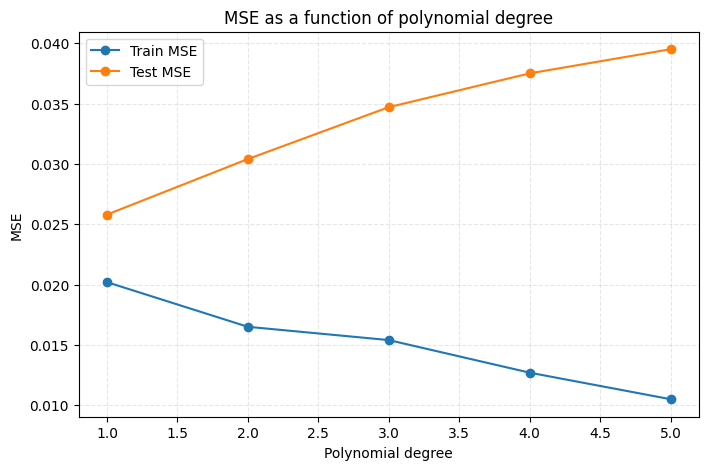

In [6]:
# We graph our MSE values

mse_train = [0.0202, 0.0165, 0.0154, 0.0127, 0.0105] 
mse_test =  [0.0258, 0.0304, 0.0347, 0.0375, 0.0395]

plt.figure(figsize=(8,5))
plt.plot(degrees, mse_train, marker = 'o', label = 'Train MSE')
plt.plot(degrees, mse_test, marker = 'o', label = 'Test MSE')

plt.xlabel('Polynomial degree')
plt.ylabel('MSE')
plt.title("MSE as a function of polynomial degree")
plt.legend()
plt.grid(True, linestyle = "--", alpha = 0.3)
plt.show()

As the graph shows, the MSE for the training sample always decreases as the degree of the polynomial increases. However, the testing sample acts the opposite way, increasing the MSE as the degree grows. Going off of this information and the fact that in a Gaussian linear regression maximizing the MLE (Maximum Likelihood Estimation) value is equal to minimizing the MSE value we can conclude that **the first degree linear function provides the best fit to model this linear regression**. This becomes clear by the fact that the first degree model is the one that maximizes the MLE in unseen data, while avoiding over-fitting.

Now that via cross-validation we know the best degree to proceed we can apply different models of regression. First we will start with Lasso regression:

The Lasso regression is a linear regression method that is characterized by adding a $L_1$-penalty to the loss function. This penalty creates sparsity between the coefficients, improving generalization and preventing over-fitting. Also, unlike ordinary least squares, Lasso can shrink some coefficients exactly to zero.

In [7]:
# We use the same data splits from last regression.

lasso = Lasso(alpha = 0.01) # Regularization strength
lasso.fit(fplane_X_train, fplane_Y_train)

# We make new predictions for cross-validation

fplane_Y_train_pred = lasso.predict(fplane_X_train)
fplane_Y_test_pred = lasso.predict(fplane_X_test)

# We calculate Coefficients

coefs = lasso.coef_
intercept = lasso.intercept_


# We calculate MSE for both samples

train_MSE = mean_squared_error(fplane_Y_train, fplane_Y_train_pred)
test_MSE = mean_squared_error(fplane_Y_test, fplane_Y_test_pred)

# We calculate R² value

r2 = r2_score(fplane_Y_test, fplane_Y_test_pred)

# We print results

print(f"Coefficients: {', '.join(f"{c:.4f}" for c in coefs)}")
print(f"Intercept: {', '.join(f"{i:.4f}" for i in intercept)}")
print(f"Train MSE: {train_MSE:.4f}")
print(f"Test MSE: {test_MSE:.4f}")
print(f"R²: {r2:.4f}")

Coefficients: 0.7270, 0.3092
Intercept: -4.1603
Train MSE: 0.0244
Test MSE: 0.0315
R²: 0.6826


Now that we have the coefficients, for a further understanding of the regression we will be comparing how the MSE behaves as the $\alpha$ (regularization strength) value increases.

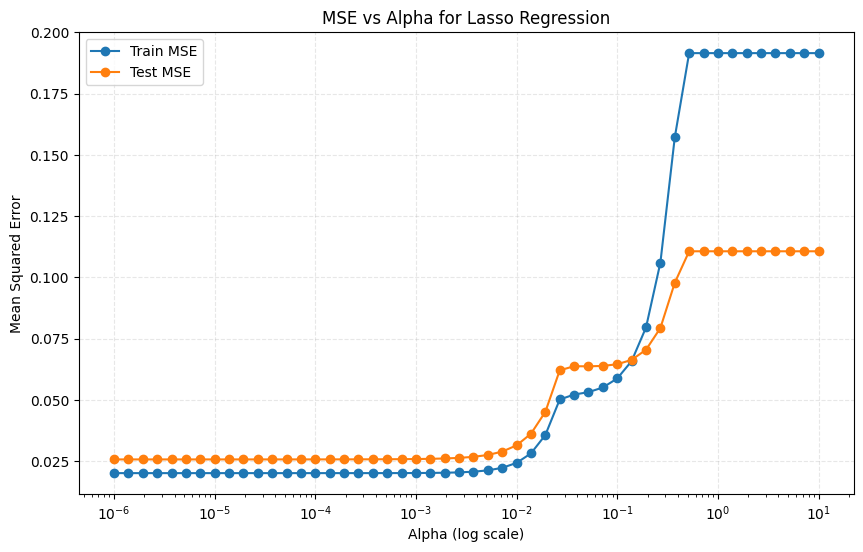

In [8]:
# We get MSE values for an interval of alphas

alphas = np.logspace(-6, 1, 50)

mse_train_list = []
mse_test_list = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(fplane_X_train,fplane_Y_train)

    fplane_Y_train_pred = lasso.predict(fplane_X_train)
    fplane_Y_test_pred = lasso.predict(fplane_X_test)

    mse_train_list.append(mean_squared_error(fplane_Y_train, fplane_Y_train_pred))
    mse_test_list.append(mean_squared_error(fplane_Y_test, fplane_Y_test_pred))

# We graph our alphas to get better visualization

plt.figure(figsize = (10,6))
plt.plot(alphas, mse_train_list, label = 'Train MSE', marker = 'o')
plt.plot(alphas, mse_test_list, label = 'Test MSE', marker = 'o')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Alpha for Lasso Regression')
plt.legend()
plt.grid(True, linestyle = '--', alpha = 0.3)
plt.show()



As we can see, the optimal $\alpha$ values for minimizing MSE are in the interval $\alpha < 0.01$.

Secondly, we will be making a Ridge regression. As with the Lasso regression, we will be using the 1st-degree function but unlike Lasso the Ridge regression is characterized for penalizing the sums of the squared coefficients and also unlike the Lasso regression this regression will not be putting coefficients to 0 (though it will make them smaller). This regression is useful for when you want to regularize your model without deleting variables.

In [9]:
# We use the same data splits from last regression.

ridge = Ridge(alpha = 0.01) # Regularization strength
ridge.fit(fplane_X_train, fplane_Y_train)

# We make new predictions for cross-validation

fplane_Y_train_pred = ridge.predict(fplane_X_train)
fplane_Y_test_pred = ridge.predict(fplane_X_test)

# We calculate Coefficients

coefs = ridge.coef_
intercept = ridge.intercept_

# We calculate MSE for both samples

train_MSE = mean_squared_error(fplane_Y_train, fplane_Y_train_pred)
test_MSE = mean_squared_error(fplane_Y_test, fplane_Y_test_pred)

# We calculate R² value

r2 = r2_score(fplane_Y_test, fplane_Y_test_pred)

# We print results

print(f"Coefficients: {', '.join(f"{c:.4f}" for c in coefs)}")
print(f"Intercept: {', '.join(f"{i:.4f}" for i in intercept)}")
print(f"Train MSE: {train_MSE:.4f}")
print(f"Test MSE: {test_MSE:.4f}")
print(f"R²: {r2:.4f}")

Coefficients: 1.1360, 0.3110
Intercept: -5.1461
Train MSE: 0.0202
Test MSE: 0.0258
R²: 0.7402


As with the Lasso regression we will graph how the MSE behaves in function of $\alpha$.

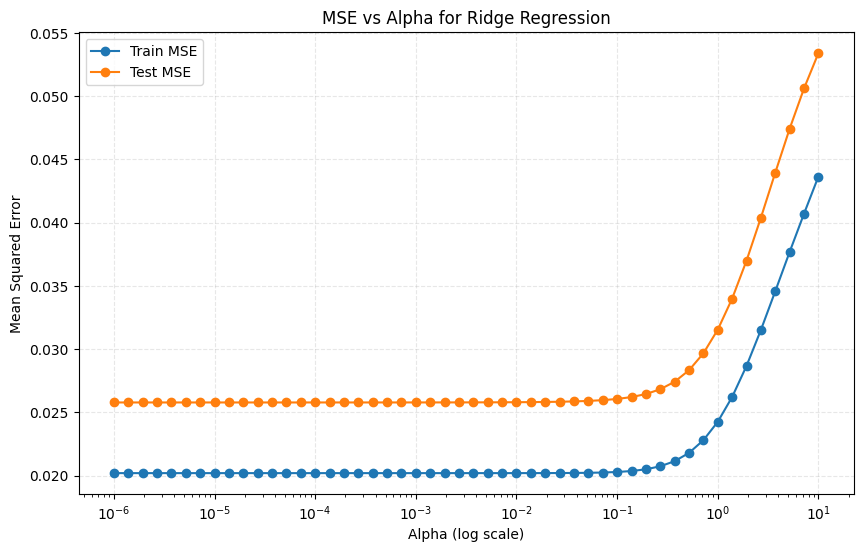

In [ ]:
# We get MSE values for an interval of alphas

alphas = np.logspace(-6, 1, 50)

mse_train_list = []
mse_test_list = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(fplane_X_train,fplane_Y_train)

    fplane_Y_train_pred = ridge.predict(fplane_X_train)
    fplane_Y_test_pred = ridge.predict(fplane_X_test)

    mse_train_list.append(mean_squared_error(fplane_Y_train, fplane_Y_train_pred))
    mse_test_list.append(mean_squared_error(fplane_Y_test, fplane_Y_test_pred))

# We graph our alphas to get better visualization

plt.figure(figsize = (10,6))
plt.plot(alphas, mse_train_list, label = 'Train MSE', marker = 'o')
plt.plot(alphas, mse_test_list, label = 'Test MSE', marker = 'o')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Alpha for Ridge Regression')
plt.legend()
plt.grid(True, linestyle = '--', alpha = 0.3)
plt.show()

In this case we can see some more expected behavior for our function, where the MSE vs $\alpha$ function looks almost like a exponential shape with the MSE minimizing $\alpha$ value being in the interval $\alpha < 0.1$ and reaching lower MSE values than those reached with the Lasso regression.

When analyzing how the coefficients behave in each of the linear regressions there's a few main differences that are worth noting:

* In the original **LinearRegression (OLS)** the coefficients adjusted only to minimize the MSE when training, this without any reduction via regularization. This usually results in bigger coefficients

* In the **Lasso regression** we can see that some coefficients can become exactly 0, this usually happens with bigger alpha values which is very useful if you suspect that not all variables are important. Other than that if you put smaller alpha values you will see very similar coefficient values to that of the OLS regression.

* Last but not least, the **Ridge regression** penalizes the sum of the squared coefficients which means that these values will decrease but rarely reach zero, which is useful when you have all the important variables but want to avoid an over-fit. Also if you put bigger values for alpha all the coefficients decrease, making them more moderate.